Işıkay KARAKUŞ

2071938

08/07/2023

#  Introduction

My objective is to train and test a powerful unsupervised generative model called a Deep Belief Network (DBN) in order to uncover meaningful features or representations within the EMNIST Dataset. Unlike traditional classifiers, the DBN does not rely on labeled data; instead, its main focus is on constructing a hierarchy of features that captures the underlying structure of the dataset.

To achieve this goal, I plan to enhance the model by combining generative models with a readout layer. The generative models will be responsible for capturing the intricate patterns and statistical regularities within the data, enabling the DBN to learn hierarchical representations. On the other hand, the readout layer will facilitate the extraction of valuable information from the generative model's output.

This project's code draws inspiration from the practical sessions of our classes, as well as the concepts covered in the labs. By building upon this foundation, I am confident in developing a robust and efficient model capable of discerning meaningful features and accurately classifying the data.

To start with, download some scripts from a GitHub repository that implement a DBN in PyTorch.

In [204]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [205]:
%%capture
get_dbn_library()

In [206]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv

from DBN import DBN

Let's choose dynamically the kind of device used for computations (CPU or GPU).

In [207]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


To load the training and testing samples specifically for the subset labeled as 'letters', the data undergoes preprocessing. This includes converting the data stored as NumPy arrays into PyTorch tensors using the ToTensor() transformation. This conversion is essential as PyTorch tensors are the required format for effectively utilizing PyTorch's neural network libraries. Additionally, a normalization step is performed on the transformed images. This normalization ensures that the pixel values lie within the range of [0, 1] by dividing each pixel value by 255.

For my models, I have trained them using a total of 124,800 images from the EMNIST Dataset. Furthermore, to evaluate the performance of these models, I have analyzed them based on a separate set of 20,800 test data points. This approach enables a comprehensive assessment of the models' capabilities and their ability to generalize to new and unseen handwritten character digits.


Then, let's download the EMNIST dataset. We download both the train and test datasets.

In [208]:
%%capture
emnist_train = tv.datasets.EMNIST('data/', split='letters', train=True, download=True,
                                  transform=tv.transforms.Compose([
                                      tv.transforms.ToTensor(),
                                      tv.transforms.Normalize((0.1307,), (0.3081,))
                                  ]))

emnist_test = tv.datasets.EMNIST('data/', split='letters', train=False, download=True,
                                 transform=tv.transforms.Compose([
                                     tv.transforms.ToTensor(),
                                     tv.transforms.Normalize((0.1307,), (0.3081,))
                                 ]))


In [209]:
print("training data size: {}".format(list(emnist_train.data.shape)))
print("test data size: {}".format(list(emnist_test.data.shape)))


training data size: [124800, 28, 28]
test data size: [20800, 28, 28]


# Preprocessing Data

The normalization step;

In [210]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

Then, i created "d" that maps each uppercase letter of the English alphabet to its corresponding position in the alphabet and creates a list associated_char containing all the uppercase letters

In [211]:
import string
d = {char: i for i, char in enumerate(string.ascii_uppercase, start=1)}
associated_char = list(string.ascii_uppercase)



In [212]:
import torchvision.transforms as transforms
def rotate(image):
    image = transforms.ToPILImage()(image)  # Convert tensor to PIL Image
    image = transforms.functional.hflip(image)  # Horizontal flip
    image = transforms.functional.rotate(image, 90)  # Rotate 90 degrees clockwise
    image = transforms.ToTensor()(image)  # Convert PIL Image back to tensor
    return image

def show_img(idx):
    img = emnist_train.data[idx]
    img_tensor = transforms.ToTensor()(img)
    img_transformed = rotate(img_tensor)

    associated_char = list(string.ascii_lowercase)
    label = associated_char[emnist_train.targets[idx]]

    print("The letter shown is: {}".format(label))
    plt.imshow(img_transformed.squeeze(), cmap='gray')
    plt.show()

In [213]:
for index, image in enumerate(emnist_train.data):
    emnist_train.data[index] = rotate(image)

for index, image in enumerate(emnist_test.data):
    emnist_test.data[index] = rotate(image)


Data augmentation involves manipulating the images in the dataset by rotating and flipping them. This helps to create more training examples and increase the size of the dataset. The main goal is to improve how well the model can understand and recognize new, unseen images. By adding variations to the original images, such as different angles and mirrored versions, the model becomes better at capturing different patterns and variations in the data. This process makes the model more robust and accurate when it comes to making predictions. In simple terms, data augmentation helps the model learn from a wider range of examples, leading to better performance and more accurate results.

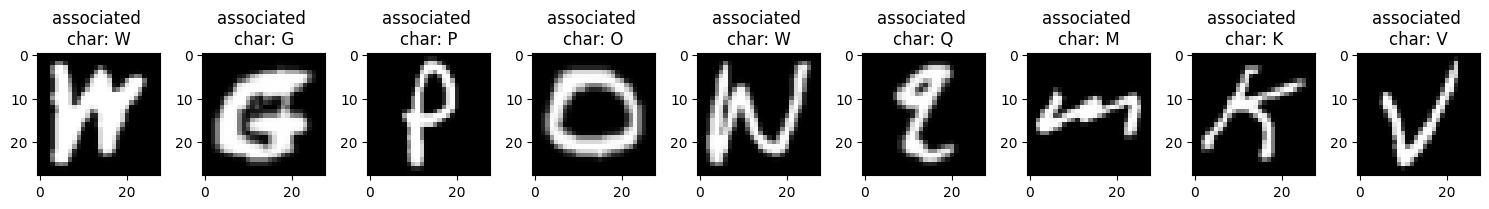

In [214]:
cols = 9
rows = 1
fig, axes = plt.subplots(rows, cols, figsize=(15, 16))

for i, ax in enumerate(axes.flat):
    ax.imshow(emnist_train.data[i].cpu(), cmap=plt.get_cmap('gray'))
    ax.set_title("associated \nchar: {}".format(associated_char[emnist_train.targets[i] - 1]))

plt.tight_layout()
plt.show()


In [215]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)

In [216]:
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

The <b>.to(device)</b> method in PyTorch allows for seamless migration of tensors or datasets between different devices, such as moving data from the CPU to the GPU. This process aims to optimize computation speed and minimize data transfer time. By transferring the data to the desired device, computations can be executed directly on that device, eliminating the need for frequent data transfers between devices. This helps in accelerating the overall computation process and improving the efficiency of the neural network model.

#DBN


A DBN (Deep Belief Network) object is instantiated using the imported DBN class. Here is a brief description of the hyperparameters:


1.  The visible units correspond to the input nodes of the network, and their number is 28x28, representing the size of a single image in pixels.
2.  The hidden units are organized in layers, and the network is composed of three layers. The first layer consists of 400 nodes, the second layer has 500 nodes, and the last layer contains 800 nodes.
3.  The parameter "k" determines the number of steps for Contrastive Divergence (CD) during training. CD is an algorithm used to update the weights of the Restricted Boltzmann Machine (RBM) within the DBN.
4.  The learning rate controls the speed of weight updates during training iterations.
5.  There is no decay applied to the learning rate, meaning it remains constant throughout the training process.
6.  Momentum is utilized at the beginning of training to accelerate the process by incorporating a fraction of the previous weight update into the new one.
7.  As training progresses and nears the final result, the momentum is decreased to aid in better convergence.
8.  A weight decay factor is introduced to penalize large weights and encourage their reduction.
9.  Xavier Initialization is not employed in this particular case.
10. The number of steps for contrastive divergence (k) remains constant throughout the entire training process.
11. If available, a GPU is utilized instead of the CPU for computation purposes.








In [217]:

dbn_emnist = DBN(visible_units=28*28,  # 28 x 28 pixels
              hidden_units=[400, 500, 800],
              k=1,  # Number of times that contrastive divergence is repeated (in this case, 1 time)
              learning_rate=0.1,  # Speed at which the learning of the network is updated
              learning_rate_decay=False,  # The learning rate remains constant throughout training
              initial_momentum=0.5,  # Optimization parameter
              final_momentum=0.9,
              weight_decay=0.0001,  # L2 optimization parameter
              xavier_init=False,
              increase_to_cd_k=False,
              use_gpu=torch.cuda.is_available())

During training, I tried different batch sizes, such as 50, 125, 250, and 500, for each training session that lasted 50 epochs.(I do not show the values ​​I tried while I was choosing the batch size on this notebook because I got a memory error after a point.)

After analyzing the results, I noticed that accuracy generally improved as the batch size became larger. However, once the batch size reached 125, the accuracy started to decrease. Based on my observations, I decided to go with a batch size of 125 since it gave me the highest accuracy.

In [218]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(emnist_train.data, emnist_train.targets, num_epochs, batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2726     |0.0402       |272.0318   |5.6712     |
|20    |1.2128     |0.0373       |257.0212   |5.2875     |
|30    |1.1918     |0.0368       |250.2210   |4.7970     |
|40    |1.1838     |0.0358       |248.0000   |4.6390     |
|50    |1.1790     |0.0359       |246.2007   |4.4313     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.6503     |0.0438       |188.2776   |3.4897     |
|20    |1.5802     |0.0399       |182.4006   |2.8698     |
|30    |1.5643     |0.0386       |180.9079   |2.9288     |
|40    |1.5575     |0.0386       |180.4371   |2.9734     |
|50    |1.5552     |0.0387       |180.1225   |3.0725     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1651     |0.0321       |226.1649   |3.8707     |
|20    |1.0795     |0.0294       |213.7546   |3.723

The network undergoes training, where the data is divided into batches at each epoch. During training, the reconstruction error is calculated and printed for each layer every 10 epochs. The reconstruction error indicates the dissimilarity between the original data and its reconstructed form. As training progresses, the reconstruction error tends to decrease, on average, with each epoch for every layer.

The variables mean_grad and std_grad represent the magnitude and variability of the gradient, respectively. It is crucial for these values to strike a balance; they should neither be excessively large nor too small. If the improvement indicated by these values is too significant, it may lead to overshooting the optimal point. Therefore, a moderate and controlled improvement is desirable to ensure progress without missing the optimal solution.

#Visualizing Receptive Fields

After completing the network training, we need to proceed to visualize the learned weights. To accomplish this, generate plots depicting selected weights in an image format that matches the size of the EMNIST images used during training. This visualization allows us to identify which regions or patterns in an image activate specific units associated with particular weight vectors.

To ensure clarity in the plots and reduce noise, we need to applied a threshold. Additionally, all values in different weight vectors are scaled uniformly to facilitate easy comparison. We present the first 100 filters learned in each layer, providing insight into what specific features or patterns each node in the network is capable of recognizing.

One important thing that since the second and third layers have different dimensionalities, we need to project them onto a 28x28 space to align with the original image dimensions. This projection ensures that the visual representation accurately corresponds to the learned weights' interpretation.

In [219]:
def get_weights(dbn, layer):
    # Retrieve the weights associated with the specified layer of the network
    return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
    # Apply a threshold to the input weights
    # Any weight value below the specified threshold is set to 0
    return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
    # Apply min-max scaling transformation to the input dataset
    # This ensures that all values in the dataset are scaled to fall within the range of 0 to 1
    original_shape = learned_weights.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
    min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
    return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
    # Visualize the weights by creating a grid of subplots
    # Each subplot represents the receptive field associated with one of the weights
    num_subplots = 100
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # Select the weights we want to plot


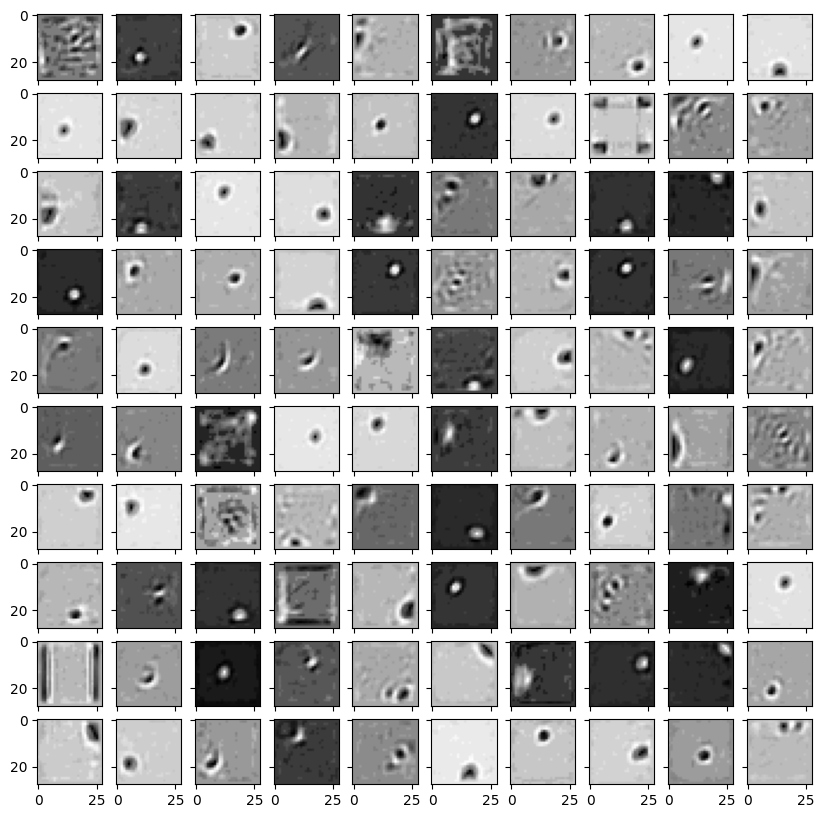

In [220]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)



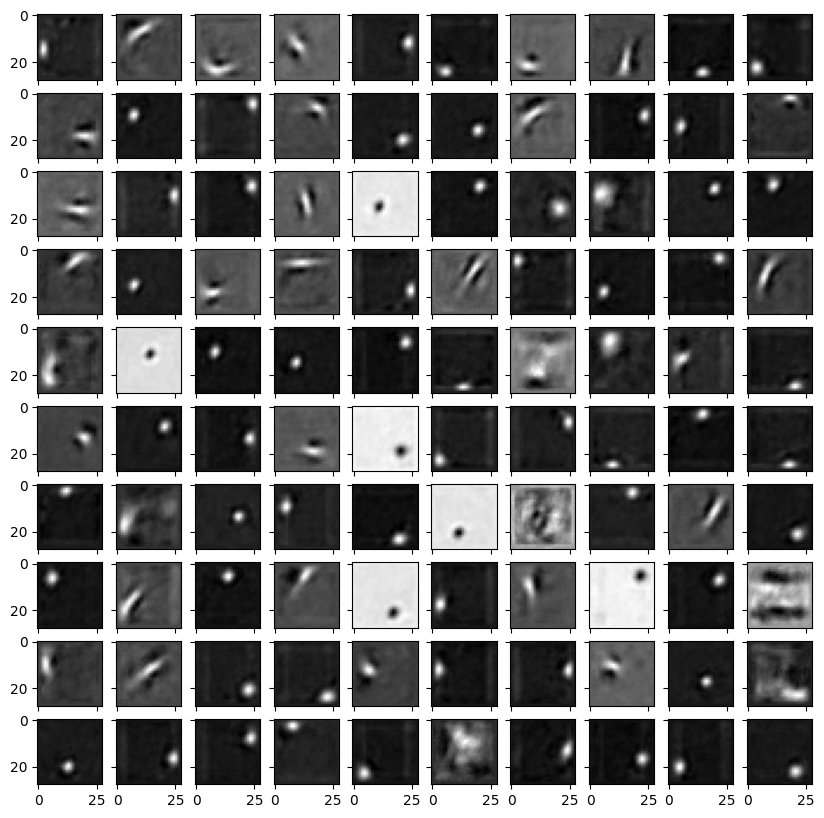

In [221]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)



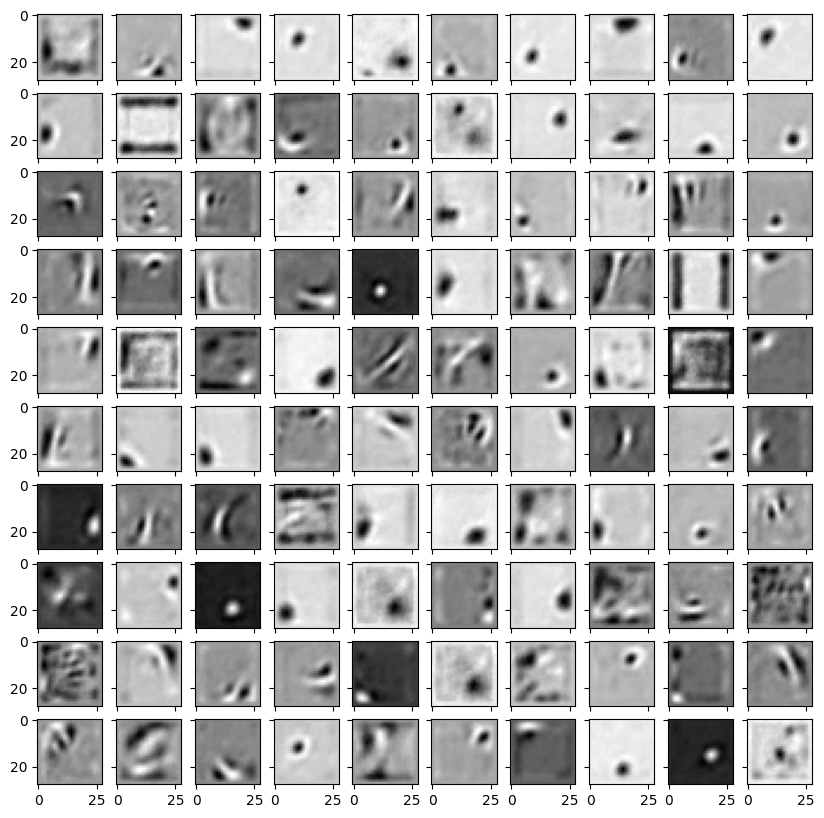

In [222]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)



##Hierarchical Clustering Representations


Next, we calculate the centroids of the representations learned for each class and examine their proximity to one another using a standard hierarchical clustering algorithm. This implementation of the Deep Belief Network (DBN) comprises multiple Restricted Boltzmann Machine (RBM) objects internally. Consequently, we need to compute the hidden representations using the weights of each RBM layer within the DBN.

To compute the representations, we utilize the learned weights of each RBM layer successively. Specifically, the representation of the second layer is derived from the representation of the previous layer, and this process continues for subsequent layers.

Once the representations are obtained, we proceed to compute the centroids for each class. These centroids serve as reference points that capture the central tendencies of the representations associated with each class. Finally, we employ a hierarchical clustering algorithm to assess the proximity of these centroids, thereby gaining insights into the relationships and similarities among different classes.

In [223]:
def get_kth_layer_repr(input, model, k, device):
    flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
    hidden_repr, __ = model.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
    return hidden_repr

In [224]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data,dbn_emnist, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1,dbn_emnist, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2,dbn_emnist, 2, device)

Our objective now is to compute the average hidden representation for each class within the EMNIST dataset and construct a matrix that encompasses all the required centroids. This matrix will have dimensions of 26xD, where D represents the number of nodes in the respective layer. Specifically, for the third layer, the matrix will be 26x800.

To achieve this, we calculate the mean hidden representation by aggregating the hidden representations of all instances belonging to a particular class. Each class is associated with a specific letter. By computing the average representation for each class, we obtain a consolidated set of centroids that encapsulate the characteristic features of the respective classes.

The resulting matrix consolidates these mean hidden representations for all 26 classes, forming a comprehensive representation of the data. This matrix serves as a valuable resource for further analysis and exploration of the learned representations within the third layer of the network.

In [225]:
def get_mask(label):  # we use this function to filter by class
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(1,27)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(1,27)])

In [226]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

Now, we proceed to execute the clustering algorithm and visualize its output through a dendrogram plot. The dendrogram provides an intuitive representation of how the data points are grouped into clusters at different levels of similarity. This visualization proves to be highly valuable in our analysis, as it clearly demonstrates the proximity or distance between classes.

We generate dendrograms for each of the three layers, highlighting the distinct clusterings formed based on the considered features within each layer. While the visual differences between the dendrograms might not be immediately apparent, upon closer examination of the branching structure, we can identify variations. For instance, closely related letters such as G and Q, I and L, and P and F consistently appear near each other in all layers.

The dendrogram plots provide valuable insights into the clustering patterns and the relationships between different classes within each layer. They help establish a clearer understanding of the distinguishing features that contribute to the unique clustering arrangements observed in each layer. Consequently, this analysis enhances our ability to discern the distinctiveness of various classes, reducing the likelihood of confusion between them.

In [227]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots(figsize=(8, 3))
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dtest=[(elem) for elem in d]
  dendrogram = cluster.hierarchy.dendrogram( linkage, labels=dtest)
  ax.set_title(title)

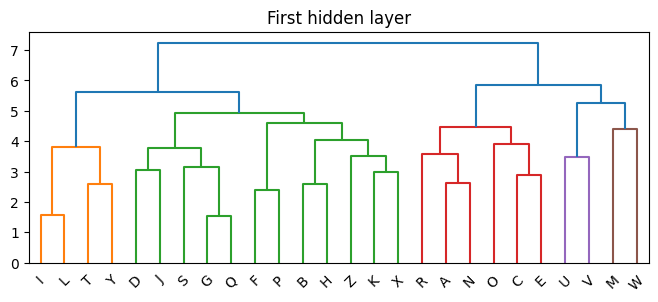

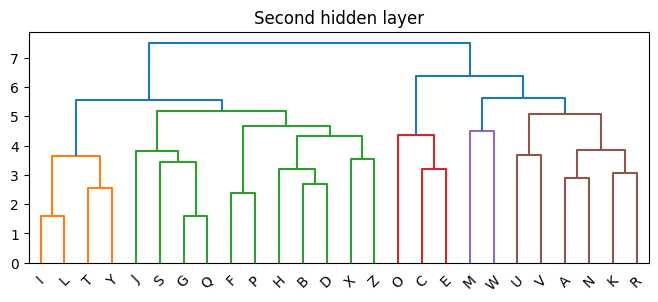

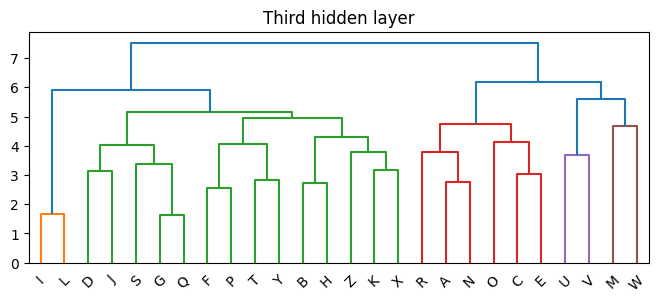

In [228]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")


# Linear Read-Out

The representations generated by the Deep Belief Network (DBN) at each layer are subjected to a linear readout process. This involves using the representations to classify the original images using a basic linear classifier. The purpose is to evaluate the amount of information contained within each hidden representation. To achieve this, a class is defined, which includes a function responsible for linearly transforming the input tensor. This transformation is carried out using a single fully connected layer. Essentially, a linear model is computed for each layer of the DBN.

In [229]:
class LinearModel(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 27)  # Change output size to 27 for EMNIST

  def forward(self, x):
    return self.linear(x)

In [230]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)



A linear classifier is defined to utilize the previously computed hidden representations from each layer. This classifier operates by using the labels from the EMNIST dataset as targets. The model employs stochastic gradient descent as the optimizer, recalculating it with each batch. By training each linear layer in this manner, it becomes evident that the loss, typically measured by cross-entropy, decreases across all three layers as the epochs progress. If the decision were made to extend the model training for more epochs, the final loss would have been further reduced. However, in order to prevent overfitting and considering that the rate of loss improvement was diminishing, a choice was made to conclude training after 1500 epochs.

In [231]:
def train(network, input, epochs=1500):
    optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = network(input).squeeze()
        targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [232]:
print("training is started")
train(linear1, hidden_repr_layer_1)
print("-----------------------------")
train(linear2, hidden_repr_layer_2)
print("-----------------------------")
train(linear3, hidden_repr_layer_3)
print("training is finished")

training is started
epoch :   1/1500, loss = 3.3248
epoch : 101/1500, loss = 2.1069
epoch : 201/1500, loss = 1.6737
epoch : 301/1500, loss = 1.4722
epoch : 401/1500, loss = 1.3560
epoch : 501/1500, loss = 1.2785
epoch : 601/1500, loss = 1.2219
epoch : 701/1500, loss = 1.1779
epoch : 801/1500, loss = 1.1422
epoch : 901/1500, loss = 1.1123
epoch : 1001/1500, loss = 1.0868
epoch : 1101/1500, loss = 1.0646
epoch : 1201/1500, loss = 1.0449
epoch : 1301/1500, loss = 1.0274
epoch : 1401/1500, loss = 1.0115
-----------------------------
epoch :   1/1500, loss = 3.3359
epoch : 101/1500, loss = 2.0701
epoch : 201/1500, loss = 1.6459
epoch : 301/1500, loss = 1.4551
epoch : 401/1500, loss = 1.3456
epoch : 501/1500, loss = 1.2724
epoch : 601/1500, loss = 1.2186
epoch : 701/1500, loss = 1.1766
epoch : 801/1500, loss = 1.1423
epoch : 901/1500, loss = 1.1136
epoch : 1001/1500, loss = 1.0890
epoch : 1101/1500, loss = 1.0674
epoch : 1201/1500, loss = 1.0483
epoch : 1301/1500, loss = 1.0312
epoch : 1401/

Moving on to the test set, the hidden representations of the three layers are computed using the trained model. Subsequently, predictions are made using this model. To evaluate the effectiveness of the linear model, an accuracy score is calculated. The obtained values for all layers hover around 0.7. This is considered reasonable as it is closer to 1, indicating that a substantial proportion of the predictions were correct.

Also, since the model was trained using a stochastic gradient optimizer, the final results can vary depending on each run. Different layers may perform differently. However, based on several tests conducted, the expected range for the final accuracy lies between 0.71 and 0.76 with a good probability. While training the model for more epochs would yield better results, doubling the number of epochs would only slightly increase the accuracy.

Furthermore,the last layer exhibits a higher accuracy compared to the preceding layers, although the overall difference is not significant.

In [233]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data,dbn_emnist, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1,dbn_emnist, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2,dbn_emnist, 2, device)


In [234]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, dbn_emnist, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, dbn_emnist, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, dbn_emnist, 2, device)

In [235]:
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)


In [236]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [237]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.7186538577079773

In [238]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.7164903879165649

In [239]:
compute_accuracy(predictions_test3, emnist_test.targets)


0.7441346049308777

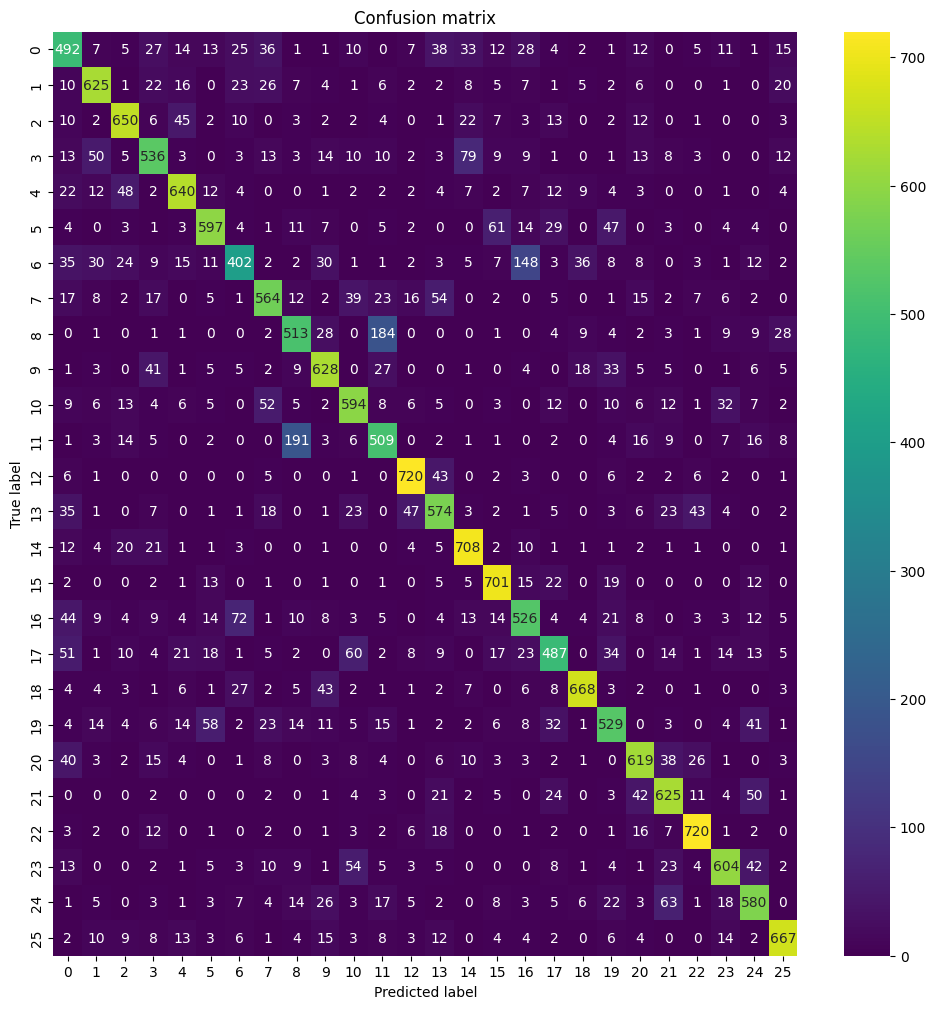

In [240]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


predictions_indices = predictions_test3.cpu().argmax(axis=1)
confusion_matrix = confusion_matrix(emnist_test.targets.cpu(), predictions_indices.cpu())
fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(confusion_matrix, annot=True, cmap='viridis', fmt="g", ax=ax)
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



#Feed-forward model

To compare the performance of a non-linear model trained end-to-end with a simple linear classifier using unsupervised learning, a feed-forward neural network (FFN) with the same structure as the DBN is trained. This FFN consists of three layers, where the first layer takes an input size of 784, corresponding to the number of pixels in an EMNIST image.

Training the FFN follows a similar process as before, with an equal number of epochs, and maintaining the same number of nodes in each layer to ensure a fair comparison. However, it is noteworthy that training the FFN requires a significantly longer time compared to the DBN. This observation can be attributed to a few factors. Firstly, DBNs leverage the hidden representations, where features have already been extracted and trained layer by layer. This initialization of weights contributes to faster training. Additionally, the fine-tuning algorithm employed by DBNs is known to be more efficient, further enhancing the speed of training.

The time-consuming nature of training the FFN can be attributed to the absence of pre-trained features and the need to learn all the parameters from scratch. In contrast, the DBN benefits from the hierarchical learning approach, enabling it to converge faster and achieve satisfactory results with less training time. This discrepancy highlights the advantages of utilizing unsupervised learning and pre-training methods, such as those employed by DBNs, for efficient and effective training of deep neural networks.








In [241]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 27)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [242]:
ffnn = Feedforward(400, 500, 800).to(device)

In [243]:
train(ffnn, emnist_train.data.reshape((124800, 784)))

epoch :   1/1500, loss = 3.2951
epoch : 101/1500, loss = 3.2565
epoch : 201/1500, loss = 3.1312
epoch : 301/1500, loss = 2.4855
epoch : 401/1500, loss = 1.8132
epoch : 501/1500, loss = 1.5037
epoch : 601/1500, loss = 1.3608
epoch : 701/1500, loss = 1.2576
epoch : 801/1500, loss = 1.1823
epoch : 901/1500, loss = 1.1147
epoch : 1001/1500, loss = 1.0537
epoch : 1101/1500, loss = 0.9974
epoch : 1201/1500, loss = 0.9440
epoch : 1301/1500, loss = 0.8942
epoch : 1401/1500, loss = 0.8474


In [244]:
predictions_ffnn = ffnn(emnist_test.data.reshape((20800, 784)))

In [245]:
compute_accuracy(predictions_ffnn, emnist_test.targets)


0.7615865468978882

## Robustness to noise

In the context of evaluating the robustness of learned representations in the Deep Belief Networks (DBNs), an important aspect is the injection of noise into the input images. This is done to examine how well the models can handle perturbations in the sensory signals and to assess the level of noise that affects their ability to produce accurate results. To achieve this, a random Gaussian noise is generated with the same shape as the input data. The noise level, which represents the variance of the Gaussian distribution, is then applied by multiplying it with the generated noise.







In [246]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor


Injecting noise into the input images serves multiple purposes in DBNs. Firstly, it adds diversity to the training data, thereby expanding the range of examples the model is exposed to. By introducing random variations, the noise helps prevent overfitting by discouraging the model from relying too heavily on specific, fine-tuned features present in the training data. This approach encourages the DBN to learn more robust and generalizable features, enabling it to perform well on a wider range of inputs.

The chosen noise intensity level for this experiment is 20%, which may be considered relatively low. However, even at this level, the effect of the noise on the resulting images becomes noticeable. By introducing controlled variations through noisy images during training, the DBN becomes more resilient to noise in real-world scenarios, enhancing its ability to accurately process and classify inputs. This data augmentation technique is valuable in deep learning as it aids in generalization, improving the model's ability to handle diverse and noisy data beyond the training set.



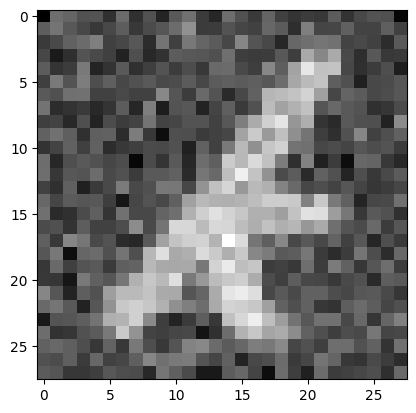

In [247]:
noise_level = 0.2
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[8312].cpu().reshape(28, 28), cmap="gray")

Next, we proceed with the computation of hidden representations for the noisy images using the RBM, following the same methodology applied in the labs. This involves feeding the noisy images into the RBM and obtaining the corresponding hidden representations. These representations capture the learned features and patterns present in the noisy input images.

Once we have obtained the hidden representations for the noisy images, we can utilize the models that were previously trained on representations without noise. These trained models are designed to classify images based on the clean representations. By employing these models, we aim to evaluate their performance in classifying the noisy images accurately. This analysis allows us to assess the robustness of the trained models against the introduced noise and gain insights into the extent to which the learned features are resilient to variations and perturbations in the input data.

In [248]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images

  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise,dbn_emnist, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy,dbn_emnist, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy,dbn_emnist, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)

  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn


In [249]:
acc = get_accuracy_values_at_noise_level(0.2)
print(f"Accuracy of H1 read-out: {acc[0]:.3f}")
print(f"Accuracy of H2 read-out: {acc[1]:.3f}")
print(f"Accuracy of H3 read-out: {acc[2]:.3f}")
print(f"Accuracy of FF network: {acc[3]:.3f}")


Accuracy of H1 read-out: 0.700
Accuracy of H2 read-out: 0.711
Accuracy of H3 read-out: 0.741
Accuracy of FF network: 0.742


Let's now get an overview of the robustness of the representations to different levels of noise:

In [250]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])



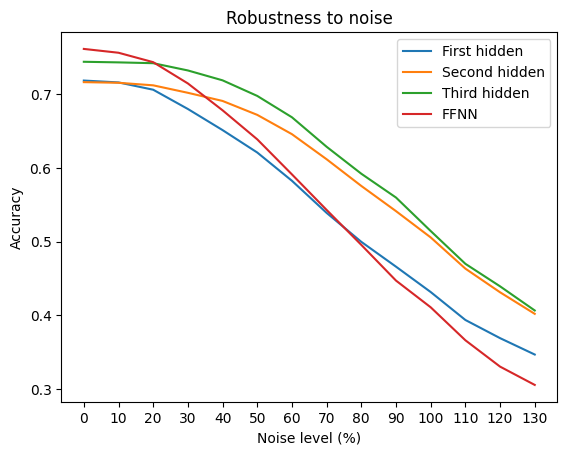

In [251]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)


# Perturbing the models with Adversarial Attacks


## Fast gradient sign method

Reference: https://jaketae.github.io/study/fgsm/

In general, with adversarial attacks we try to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure:
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [387]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image


We define a read-out classifier that utilizes the DBN classifier we defined earlier. The set of pre-trained linear classifiers act as the building blocks for generating the final prediction. The DBN serves as a feature extractor, extracting meaningful features from the input data. In this specific scenario, the third layer of the DBN is employed as the read-out layer during the inference phase.

By leveraging the power of backpropagation, this read-out classifier can be easily fine-tuned to adapt to specific requirements or tasks. The backpropagation algorithm enables the model to adjust its parameters and optimize its performance based on the desired objectives. This flexibility allows us to fine-tune the read-out classifier to improve accuracy and overall prediction performance, making it adaptable to different application scenarios.

#Adversarial samples

In [388]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [389]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

The original value of the sample is A.


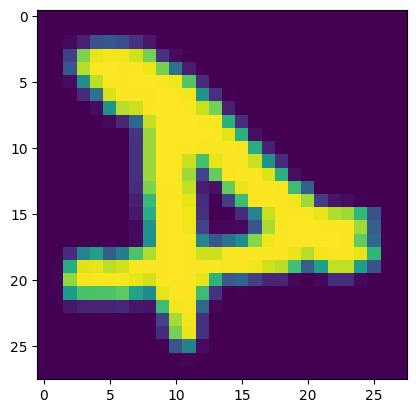

In [390]:
test_sample_idx = 9
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(tv.transforms.functional.hflip(test_image).reshape(28,28).rot90(k = 1).to('cpu'))
print(f"The original value of the sample is {associated_char[int(emnist_test.targets[test_sample_idx]) - 1]}.")


In [391]:
attacked_model = ffnn
attacked_model = dbn_with_readout

In [396]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {associated_char[int(prediction)-1]}.")

The prediction of the model for this clean sample is A.


We proceed to visualize the corresponding adversarial sample by subjecting a single image to an attack. The attack involves introducing a perturbation of 0.2 for each pixel in the image. This perturbation aims to deceive the model and misclassify the input image.

After applying the perturbation, we observe that the new prediction differs from the original value. In this specific case, the attack successfully misclassifies the input image, demonstrating the vulnerability of the model to adversarial attacks. The perturbation introduced by the attack subtly alters the image in a way that leads the model to make an incorrect prediction. This outcome highlights the importance of robustness and security considerations in deep learning models to mitigate the impact of potential adversarial attacks.

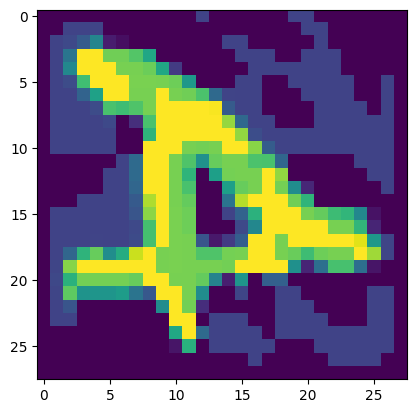

In [397]:
epsilon = 0.2 # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0) # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label) # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(np.rot90(perturbed_image_np.reshape(28,28), k = 3))

In [400]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {associated_char[int(torch.argmax(model_outputs))-1]}.")

The prediction of the model for the perturbed sample is A.


### Resisting to adversarial attacks


Now, let's evaluate and contrast the resilience of our two models,the feedforward network and the DBN, against adversarial attacks.

Additionally, we will assess the DBN's capability to mitigate the impact of these attacks through a reconstruction step. This process involves reconstructing the visible units from the hidden representation of the last layer and then going back to reconstruct the hidden representation once again.

In [404]:
import torch.nn.functional as functional
from tqdm.notebook import tqdm
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(np.flip(np.rot90(data[0].detach().to('cpu').numpy().reshape(28,28), k = 3), axis = 1))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(np.flip(np.rot90(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), k = 3), axis = 1))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                i = 0
                if i < 2: pass
                i += 1
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(np.flip(np.rot90(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), k = 3), axis = 1))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [405]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', train=False, download=False, split = 'letters', transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

### Effect of the noise parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [409]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25,0.30,0.35,0.40,0.45,0.50]

def test_epsilon_values_effect(model, n_steps):
    accuracies = list()

    for eps in epsilon_values:
        acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps)
        accuracies.append(acc)

    return accuracies

In [410]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_dbn_5 = test_epsilon_values_effect(dbn_with_readout, n_steps=5)
accuracies_dbn_10 = test_epsilon_values_effect(dbn_with_readout, n_steps=10)

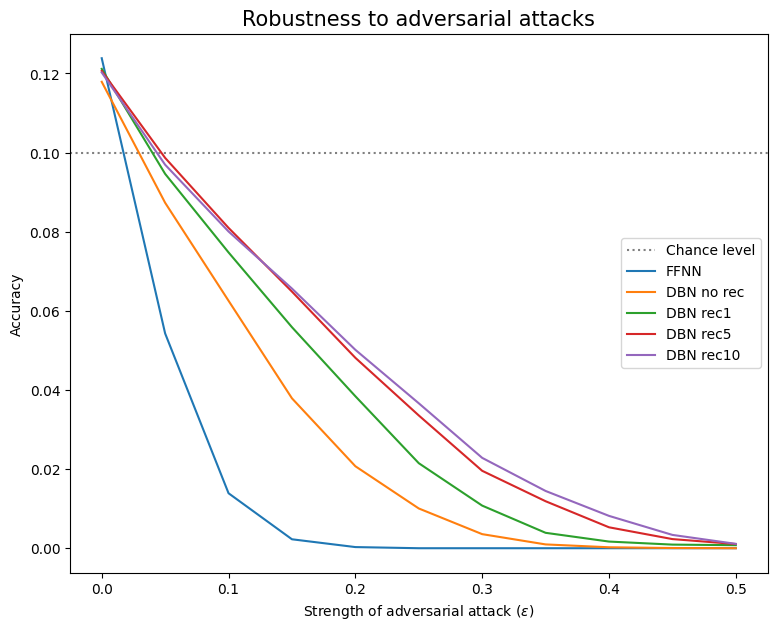

In [411]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

ax.axhline(0.1, color='gray', linestyle=':')
ax.plot(epsilon_values, accuracies_ffnn)
ax.plot(epsilon_values, accuracies_dbn_0)
ax.plot(epsilon_values, accuracies_dbn_1)
ax.plot(epsilon_values, accuracies_dbn_5)
ax.plot(epsilon_values, accuracies_dbn_10)
ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
ax.set_ylabel("Accuracy")
ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
ax.legend(["Chance level", "FFNN", "DBN no rec", "DBN rec1","DBN rec5","DBN rec10"])
plt.savefig("adversarial_attack.png")

#Conclusion

Through a series of experiments conducted in this notebook, the superiority of the Deep Belief Network (DBN) over the Feedforward Neural Network (FFN) has been demonstrated. The DBN consistently outperformed the FFN in all the tests that were conducted. It is important to note that this does not imply that the FFN is inherently a poor model. Instead, it suggests that the DBN excels when it comes to simulating human perception.

In the experiments, both models were subjected to various challenges such as small noise and adversarial attacks on images. While these challenges may seem trivial to humans who can effortlessly differentiate them, neural networks face difficulties in handling such tasks. However, the DBN showcased its capabilities by effectively handling these challenges.

This highlights the strength of the DBN as a model that can closely simulate human perception. Its ability to perform well in the face of noise and attacks suggests that it has a higher level of robustness and adaptability. By capturing the underlying hierarchical structure of the data, the DBN leverages its deep architecture to model complex patterns and variations, enabling it to excel in scenarios that require human-like perception.






## Reference papers

- [G. Hinton - A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
- [G. Hinton, R. Salakhutdinov - Reducing the Dimensionality of Data with Neural Networks](https://www.science.org/doi/10.1126/science.1127647)
- [Testolin et al. - Deep unsupervised learning on a desktop PC: a primer for cognitive scientists](https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00251/full)
- [A. Fischer, C. Igel - Training restricted Boltzmann machines: An introduction](https://www.sciencedirect.com/science/article/pii/S0031320313002495)
- Lecture Labs